# Assignment — (Sub)graph-level tasks

### Preparations

In [ ]:
#!pip install -U -q dgl
!pip install -U -q dgl==0.8.1 dglgo -f https://data.dgl.ai/wheels/repo.html -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.7/572.7 kB 14.9 MB/s eta 0:00:

In [ ]:
import networkx as nx
import numpy as np
from dgl.data import DGLDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from torch import nn
from dgl.nn import GraphConv
from dgl.dataloading import GraphDataLoader
import pandas as pd
import dgl
from tqdm import tqdm
from torch.utils.data import Subset
from dgl.nn import GraphConv, AvgPooling
import torch.nn as nn
from torch.utils.data import DataLoader
import torch
from torch.optim import Adam
from IPython.display import clear_output
from sklearn.manifold import TSNE
import requests

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


### Task 1. Dataset description (0 points)

Previously we have studied the graph neural networks that allow us to obtain node embeddings. However, there are several (sub)graph-level tasks, e.g. molecular property prediction. To solve it, we should be able to receive full graph embedding. This seminar concentrates on several graph pooling techniques.

We will experiment with the [Graph Property Prediction dataset](https://ogb.stanford.edu/docs/graphprop/), more precisely with `ogbg-molhiv`.
The dataset contains several graphs adopted from [MoleculeNet](https://pubs.rsc.org/en/content/articlehtml/2018/sc/c7sc02664a), each graph represents the molecule, where nodes are atoms, and edges are chemical bonds. Input node features are 9-dimensional, containing atomic number and chirality, as well as other additional atom features such as formal charge and whether the atom is in the ring or not.

In the next cell we load dataset from `ogb` library, split it into train, validation and test subsets and create pytorch dataloaders.

In [ ]:
! pip install -q ogb

In [ ]:
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder
from ogb.graphproppred import DglGraphPropPredDataset, collate_dgl, Evaluator

dataset = DglGraphPropPredDataset(name="ogbg-molhiv")

split_idx = dataset.get_idx_split()
train_loader = DataLoader(dataset[split_idx["train"]], batch_size=32, shuffle=True, collate_fn=collate_dgl)
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=32, shuffle=False, collate_fn=collate_dgl)
test_loader = DataLoader(dataset[split_idx["test"]], batch_size=32, shuffle=False, collate_fn=collate_dgl)

Downloaded 0.00 GB: 100%|██████████| 3/3 [00:00<00:00,  7.76it/s]


Extracting dataset/hiv.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 41127/41127 [00:00<00:00, 48236.46it/s]


Converting graphs into DGL objects...


100%|██████████| 41127/41127 [00:23<00:00, 1728.14it/s]


Saving...


In [ ]:
dataset[split_idx["train"]][0]

(Graph(num_nodes=24, num_edges=50,
       ndata_schemes={'feat': Scheme(shape=(9,), dtype=torch.int64)}
       edata_schemes={'feat': Scheme(shape=(3,), dtype=torch.int64)}),
 tensor([0]))

In [ ]:
import networkx as nx

labels = dataset.labels.detach().cpu().numpy()
pos = np.where(labels)[0]  # choose positive labels
pos

array([   11,    16,    80, ..., 41093, 41098, 41099])

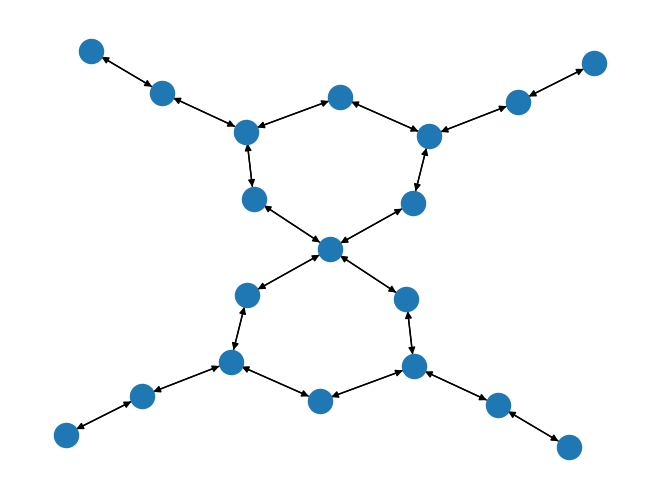

In [ ]:
nx.draw_kamada_kawai(dataset.graphs[0].to_networkx())

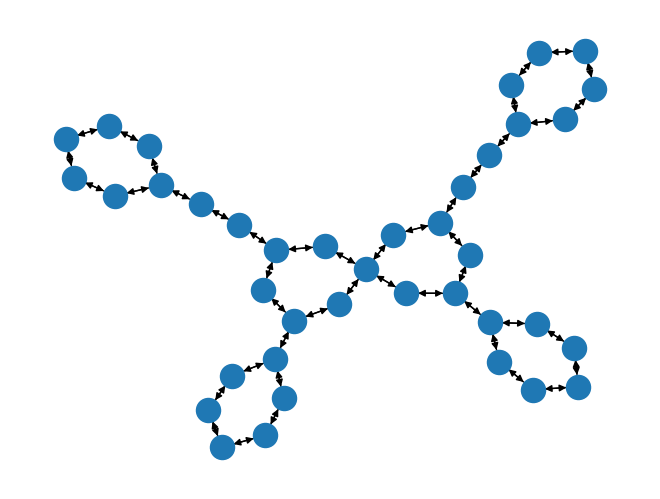

In [ ]:
nx.draw_kamada_kawai(dataset.graphs[1].to_networkx())

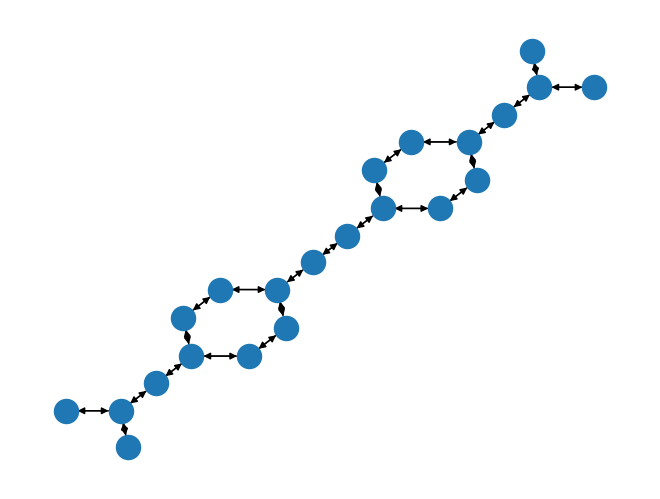

In [ ]:
nx.draw_kamada_kawai(dataset.graphs[pos[0]].to_networkx())

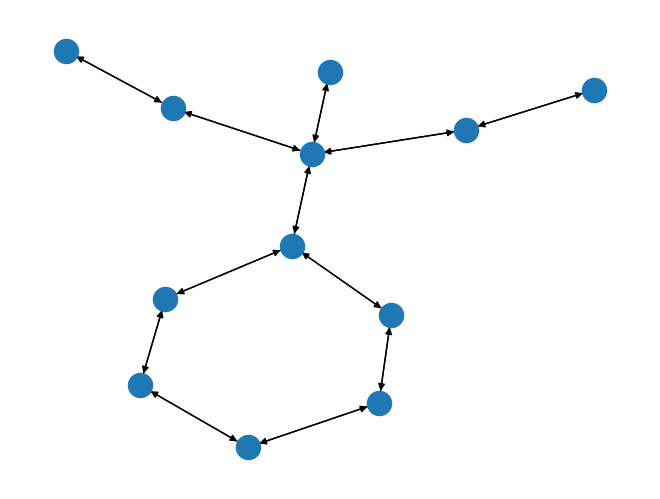

In [ ]:
nx.draw_kamada_kawai(dataset.graphs[pos[1]].to_networkx())

### Task 2. DGL for multiple graphs (0 points)

Previously, we have used DGL to work with one graph. However, it is also suitable for working in multiple graphs scenario.

DataLoader encodes multiple graphs as one large graph. Nodes of it each graph are grouped. To reconstruct whether the specific graph is, we can use `graph.batch_num_nodes()`. This function will return tensor with number of nodes in each graph.

For example, in the next cell we will extract the first element from the `train_loader`.

In [ ]:
graphs, labels = train_loader.__iter__().__next__()
graphs, labels

(Graph(num_nodes=735, num_edges=1550,
       ndata_schemes={'feat': Scheme(shape=(9,), dtype=torch.int64)}
       edata_schemes={'feat': Scheme(shape=(3,), dtype=torch.int64)}),
 tensor([[0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0]]))

In [ ]:
graphs.batch_num_nodes()

tensor([12, 15, 32, 29, 26, 23, 18, 17, 35, 44, 21, 16, 32, 18, 23, 17, 25, 11,
        21, 23, 20, 24, 22, 20, 29, 16, 16, 25, 20, 22, 26, 37])

In [ ]:
sum(graphs.batch_num_nodes())

tensor(735)

From that we can reconstruct the graph indicator and manually aggregate data over it. However DGL has several predefined functions for this case: `dgl.sum_nodes`, `dgl.mean_nodes`, `dgl.max_nodes`, `dgl.min_nodes`. These functions have similar signatures, e.g., `dgl.sum_nodes(graph, "feat")`. The second parameter aggregates the attribute name in `graph.ndata` which is a dictionary that contains node-level properties as a `torch.tensor` for all vertices. You can assign any value here. It is usefull when we use message-passing approach to pass the hidden features.

For example, let us check what data it currently contains

In [ ]:
graphs.ndata['feat']

tensor([[5, 0, 4,  ..., 2, 0, 0],
        [5, 0, 4,  ..., 2, 0, 0],
        [5, 0, 4,  ..., 2, 0, 0],
        ...,
        [5, 0, 3,  ..., 1, 1, 1],
        [5, 0, 3,  ..., 1, 1, 1],
        [5, 0, 3,  ..., 1, 1, 1]])

In [ ]:
graphs.ndata['feat'].shape

torch.Size([735, 9])

Currently, graph has only default features under the `"feat"` parameter. The pooling functions works only with float features but `"feat"` are categorical (Long) labels. For demostration purpose we can convert it to `torch.FloatTensor` and assign to the new field named `"float_feat"`.

In [ ]:
graphs.ndata["float_feat"] = graphs.ndata["feat"].to(torch.float32)
print(f'{graphs.ndata["float_feat"]}\n {graphs.ndata["float_feat"].shape}')

tensor([[5., 0., 4.,  ..., 2., 0., 0.],
        [5., 0., 4.,  ..., 2., 0., 0.],
        [5., 0., 4.,  ..., 2., 0., 0.],
        ...,
        [5., 0., 3.,  ..., 1., 1., 1.],
        [5., 0., 3.,  ..., 1., 1., 1.],
        [5., 0., 3.,  ..., 1., 1., 1.]])
 torch.Size([735, 9])


Now, we are able to aggregate graph features

In [ ]:
mean = dgl.mean_nodes(graphs, "float_feat")
print(f'{mean}\n{mean.shape}')

tensor([[5.5000, 0.0000, 3.1667, 5.0000, 1.3333, 0.0000, 1.5000, 0.0000, 0.0000],
        [5.8667, 0.0000, 2.8667, 5.0000, 0.7333, 0.0000, 1.1333, 0.8000, 0.8000],
        [6.2500, 0.0000, 2.6875, 5.0000, 0.6250, 0.0000, 1.1875, 0.3750, 0.3750],
        [7.2759, 0.0000, 2.9655, 5.0000, 0.8966, 0.0000, 1.3448, 0.4138, 0.4138],
        [5.3077, 0.0000, 3.3077, 5.0000, 1.3077, 0.0000, 1.5385, 0.0000, 0.2308],
        [5.2609, 0.0000, 3.0435, 5.0000, 0.6957, 0.0000, 1.2609, 0.5217, 0.9130],
        [6.0556, 0.0000, 2.8333, 5.0000, 0.8333, 0.0000, 1.2778, 0.3333, 0.3333],
        [5.5882, 0.0000, 2.4706, 5.0000, 0.4706, 0.0000, 0.8824, 0.2941, 0.2941],
        [5.5143, 0.0000, 2.6857, 5.0000, 0.4571, 0.0000, 1.0571, 0.6000, 0.7429],
        [5.5000, 0.0000, 3.0455, 5.0000, 1.0455, 0.0000, 1.3864, 0.1364, 0.1364],
        [5.7619, 0.0000, 3.1429, 5.0000, 1.1429, 0.0000, 1.4762, 0.2857, 0.5714],
        [5.8125, 0.0000, 2.5625, 5.0000, 0.5625, 0.0000, 1.2500, 0.6875, 0.6875],
        [5.6875,

Let us check that number of lines is equal to the number of graphs in the batch

In [ ]:
assert mean.size(0) == train_loader.batch_size

### Task 3. Sum, mean and max pooling (0 points)

Previously, we have studied GNNs. To receive node embeddings, usually, one use some operator that aggregates adjacent node embeddings. We can use similar approach for the whole graphs. In the task, we will implement the classic methods of graph-level pooling with further prediction of graph class, e.g, whether a molecule inhibits HIV virus replication or no.

In [ ]:
class SimplePooling(nn.Module):
    def __init__(self, atom_dim=8, out_dim=1, pooling_func='sum'):
        """
        Simple neural network that encodes atoms, pool it with sum, max or mean aggregation.
        In the task you need to instantiate AtomEncoder, pooling function
        and projection (fully-connected) layer from embedding dimension to output dimension

        :param atom_dim: dimension of atom embedding for AtomEncoder (int)
        :param out_dim: dimension of output (int)
        :param pooling_func: name of pooling function (str)
                             could be one of 'sum', 'mean' or 'max'.
                             You need to use proper aggregation function described above
        """
        super(SimplePooling, self).__init__()
        self.atom_encoder = AtomEncoder(emb_dim=atom_dim)
        self.pooling_func = getattr(dgl, f"{pooling_func}_nodes")
        self.fc = nn.Linear(atom_dim, out_dim)

    def forward(self, graph):
        """
        Encodes the atom in the graph, pool vertices over graphs and predict the target

        :param graph: dgl graph with batch of graphs
        """
        graph.ndata['h'] = self.atom_encoder(graph.ndata["feat"])
        return self.fc(self.pooling_func(graph, 'h'))

We are trying to solve classification task, so we can use the binary cross-entropy loss.

In [ ]:
criterion = nn.BCEWithLogitsLoss()

Let us define the `train` method. It iterates over batches and for each batch do the following:
1. calculates forward pass with model
2. moves to zero the gradient of previous step in optimizer
3. calculates the loss according to the criterion
4. backwards the loss
5. does optimization step

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

def train(model, loader, optimizer):
    """
    Train loop for model. Do not forget to switch model to train mode and place all tensors to device

    :param model: neural net that we want to train
    :param loader: data loader
    :param optimizer: optimizer for given network
    """
    model.train()
    for batch, label in tqdm(loader):
        batch = batch.to(device)
        batch.ndata['feat'] = batch.ndata['feat'].to(device)
        batch.edata['feat'] = batch.edata['feat'].to(device)
        label = label.to(device)
        logits = model(batch)
        optimizer.zero_grad()
        loss = criterion(logits.to(torch.float32), label.to(torch.float32))
        loss.backward()
        optimizer.step()

We also need the evaluation method, which will return the metrics for the task. The `ogb` library already has the `Evaluator` class. Let us instantiate it.

In [ ]:
evaluator = Evaluator("ogbg-molhiv")

Evaluator.eval method takes the python dict with ground truth (`y_true` key) and predicted (`y_pred` key) labels. It returns the dictionary with metrics. The `rocauc` metric for the given dataset is used. In the evaluate function we need to iterate over batches in the `loader` and predict the labels.

In [ ]:
def evaluate(model, loader, evaluator):
    """
    Evaluation method (do not forget to switch model mode to eval).
    Calculates the `rocauc` metric.

    :param model: model for validation
    :param laoder: data loader with data for evaluation
    :param evaluator: ogb.Evaluator for metric calculation
    """
    model.eval()
    y_true = []
    y_pred = []
    for batch, label in tqdm(loader):
        batch = batch.to(device)
        batch.ndata['feat'] = batch.ndata['feat'].to(device)
        batch.edata['feat'] = batch.edata['feat'].to(device)
        label = label.to(device)
        p = model(batch)
        y_true.append(label.view(p.shape).detach().cpu())
        y_pred.append(p.detach().cpu())
    y_true = torch.cat(y_true, dim=0).numpy()
    y_pred = torch.cat(y_pred, dim=0).numpy()

    input_dict = {"y_true": y_true, "y_pred": y_pred}

    return evaluator.eval(input_dict)

And finally, we need to define the runner function that will train and evaluate model for several epochs with early stopping, where validation score tends to descrease. Also we can use following early stopping configuration.

In [ ]:
class EarlyStopping:
    def __init__(self, patience=10, exp_name='pooling'):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.exp_name = exp_name + '_es_checkpoint.pt'

    def step(self, acc, model):
        score = acc
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0
        return self.early_stop

    def save_checkpoint(self, model):
        '''Saves model when validation loss decrease.'''
        torch.save(model.state_dict(), self.exp_name)

In [ ]:
def run(model, exp_name, patience=5, num_epochs=1):
    """
    Runner function to train and evaluate the model

    :param model: neural network for training and validation
    :param exp_name: name of experiment
    :param patience: number of rounds for early-stopping
    :param num_epochs: number of epochs
    """

    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    stopper = EarlyStopping(patience, exp_name)
    scores = {
      "train": [],
      "validation": [],
      "test": [],
    }
    for epoch in range(num_epochs):
        print(f"=======Epoch {epoch + 1}")
        train(model, train_loader, optimizer)

        scores['train'].append(evaluate(model, train_loader, evaluator)["rocauc"])
        scores['validation'].append(evaluate(model, valid_loader, evaluator)["rocauc"])
        scores['test'].append(evaluate(model, test_loader, evaluator)["rocauc"])

        clear_output()
        plt.title(f"Score dynamics. train: {scores['train'][-1]:.4f}, validation: {scores['validation'][-1]:.4f}, test: {scores['test'][-1]:.4f}")
        plt.plot(scores['train'], label="train")
        plt.plot(scores['validation'], label="validation")
        plt.plot(scores['test'], label="test")
        plt.legend()
        plt.show()

        if stopper.step(scores['validation'][-1], model):
            print(f"{exp_name} test quality: {scores['test'][-patience - 1]}")
            break
        else:
            print(f"{exp_name} test quality: {scores['test'][-1]}")

Now we can validate our pooling approaches

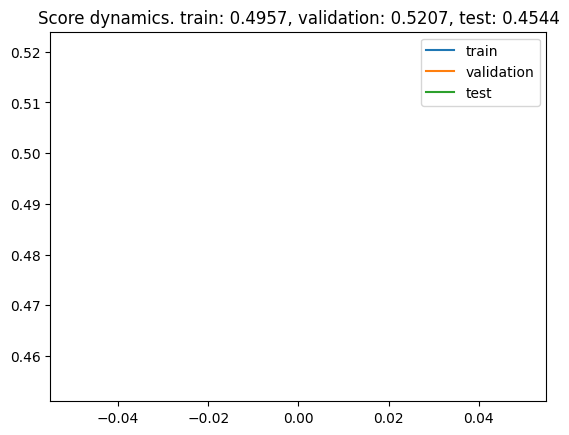

max_pooling test quality: 0.4543569786979277


In [ ]:
max_model = SimplePooling(out_dim=dataset.num_tasks, pooling_func='max').to(device)
run(max_model, "max_pooling")

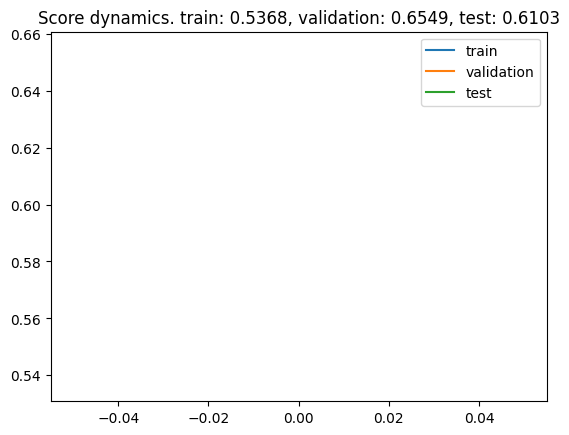

mean_pooling test quality: 0.6102551227331543


In [ ]:
mean_model = SimplePooling(out_dim=dataset.num_tasks, pooling_func='mean').to(device)
run(mean_model, "mean_pooling")

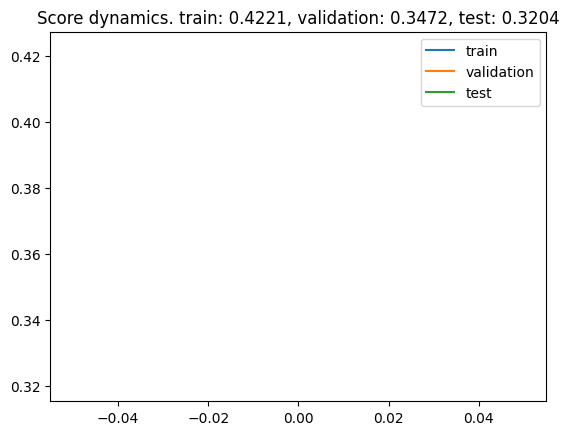

sum_pooling test quality: 0.32043299407095543


In [ ]:
sum_model = SimplePooling(out_dim=dataset.num_tasks, pooling_func='sum').to(device)
run(sum_model, "sum_pooling")

### Task 4. DeepSet pooling (0 points)

The paper: https://arxiv.org/abs/1703.06114

Simple aggregation of set element embedding could produce the wrong whole graph embedding, because we try to aggregate continuously discrete structures. So, one of the methods to eliminate it is the Deep Sets.

Deep Sets employs an idea that feed-forward neural networks are the universal estimators. Authors proves the theorem that for working with permutation invariant aggregation (e.g. summation) we can use as following:

$$\text{DeepSetPooling} = \text{MLP}_\phi \left(\sum_{v\in N} \text{MLP}_\theta (h_v)\right)$$

In [ ]:
class DeepSetPooling(nn.Module):
    def __init__(self, atom_dim=8, num_layers_deep_set=3, hidden_dim=8, num_out_layers=2, out_dim=1):
        super(DeepSetPooling, self).__init__()
        self.atom_encoder = AtomEncoder(emb_dim=atom_dim)
        self.pooling_func = dgl.sum_nodes
        self.deepsets = [nn.Linear(atom_dim, hidden_dim)]
        for _ in range(num_layers_deep_set - 1):
            self.deepsets.append(nn.Linear(hidden_dim, hidden_dim))
        self.deepsets = nn.ModuleList(self.deepsets)
        self.out_layers = []
        for _ in range(num_out_layers - 1):
            self.out_layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.out_layers.append(nn.Linear(hidden_dim, out_dim))
        self.out_layers = nn.ModuleList(self.out_layers)
    
    def forward(self, graph):
        graph.ndata['h'] = self.atom_encoder(graph.ndata["feat"])
        for fc in self.deepsets:
            graph.ndata['h'] = fc(graph.ndata['h'])
            graph.ndata['h'] = F.relu(graph.ndata['h'])
        graph_vec = self.pooling_func(graph, 'h')
        for fc in self.out_layers[:-1]:
            graph_vec = fc(graph_vec)
            graph_vec = F.relu(graph_vec)
        return self.out_layers[-1](graph_vec)

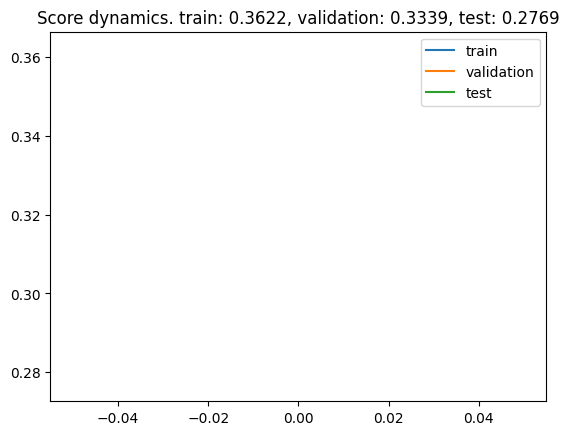

deepset_pooling test quality: 0.2768651383765619


In [ ]:
deepset_model = DeepSetPooling(out_dim=dataset.num_tasks).to(device)
run(deepset_model, "deepset_pooling")

### Task 5. DiffPool for graph coarsening (0 points)

The previous methods omit the graph structure because it simply pools the node embeddings.

To solve this issue, we will try technique named graph coarsening, specifically we will realised simplified version of the paper [Hierarchical Graph Representation Learning with Differentiable Pooling](https://arxiv.org/abs/1806.08804). It is an iterative procedure consisting of several steps:

1. Train GNN to predict node clusters (learn cluster assignment matrix $S$).

  In the step we simply apply GCN layer to our graph with feature projection to a lower dimension size. Then we normalize matrix with softmax over the feature dimension. Received matrix is the $S$.

2. Coarse the graph to the graph of clusters

  Calculate coarse adjacency matrix projecting original matrix with assignment one
$$A^\text{new} = S^\top A S$$
  Calculate the node level features with node embedding pooling
$$X^\text{new} = S^\top X$$
3. Repeat steps 1-2 several times
4. Use set polling technique to receive the graph embedding

Due to on-flight calculation of matrix $A^\text{new}$, it will be easier to work with GCN in vanilla way (project features with linear layer and then aggregate over the adjacency matrix).

Firstly, we will define an `DiffPoolLayer`

This layer realise the first two steps of the algorithm described above. More precisely, we can follow this steps to realise the `forward` method:

1. It takes adjacency matrix, node features and list with number of nodes in each batch.
2. Then it calculates the assign tensor with vanilla gcn: linear projection of hidden features, aggregation of features over the neighbours (matrix multiplication between adjacency and received feature projection)
3. Assign tensor is normalized with softmax over the feature dimension
4. Assign tensor is splitted into list of blocks based on number of nodes for each graph in batch
5. Splitted assign tensor is converted to the block diagonal matrix
6. Then it passes features through the GCN to receive new hidden representations of it.
7. New hidden features is calculated by matrix multiplication between assign matrix and features from 6
8. New adjacency matrix is calculated with projection by assign matrix
9. Return new adjacency and new features.

In [ ]:
class DiffPoolLayer(nn.Module):
    def __init__(self, input_dim, assign_dim, out_feature_dim):
        super(DiffPoolLayer, self).__init__()
        self.feature_layer = nn.Sequential(
            nn.Linear(input_dim, out_feature_dim),
            nn.Linear(out_feature_dim, out_feature_dim)
        )
        self.pooling_layer = nn.Linear(input_dim, assign_dim)
    
    def gcn_with_adj(self, adj, h, layer):
        h = layer(h)
        return adj @ h / (adj.sum(dim=1, keepdims=True) + 1e-20)
  
    def forward(self, adj, h, batch_num_nodes):
        s = self.gcn_with_adj(adj, h, self.pooling_layer)
        s = F.softmax(s, dim=1)
        s = torch.split(s, batch_num_nodes)
        s = torch.block_diag(*s)
        f = self.gcn_with_adj(adj, h, self.feature_layer)
        f_new = s.t() @ f
        adj_new = s.t() @ adj @ s
        return adj_new, f_new

This layer will be used in the `DiffPool` neural network. Network iteratively coarse the graph using the `DiffPoolLayer` in `n_layers` coarsening steps and node number fall with `poolrate`.

1. Firstly, we extract the adjacency matrix and convert it to dense tensor
2. Extract `batch_num_nodes` into python list.
3. Encode atom features
4. Iterate over pooling layers
5. Take a mean of calculated vectors
6. Predict the label

In [ ]:
class DiffPool(nn.Module):
    def __init__(self, atom_dim, hidden_dim, initial_assign_size=8, out_dim=1, n_layers=3, poolrate=0.5):
        super(DiffPool, self).__init__()
        self.poolrate = poolrate
        self.initial_assign_size = initial_assign_size
        self.atom_encoder = AtomEncoder(emb_dim=atom_dim)
        self.atom_dim = atom_dim
        input_dim = atom_dim
        self.pool_layers = [DiffPoolLayer(input_dim, initial_assign_size, hidden_dim)]
        for _ in range(n_layers - 1):
            initial_assign_size = int(initial_assign_size * poolrate)
            self.pool_layers.append(DiffPoolLayer(hidden_dim, initial_assign_size, hidden_dim))
        self.pool_layers = nn.ModuleList(self.pool_layers)
        self.fc = nn.Linear(hidden_dim, out_dim)
  
    def forward(self, graph):
        adj = graph.adjacency_matrix(transpose=True, ctx=device)
        batch_num_nodes = graph.batch_num_nodes().tolist()
        h = self.atom_encoder(graph.ndata["feat"])
        sz = self.initial_assign_size
        adj = adj.to_dense()
        for i, layer in enumerate(self.pool_layers):
            adj, h = layer(adj, h, batch_num_nodes)
            batch_num_nodes = [sz] * graph.batch_size
            sz = int(sz * self.poolrate)
        h = dgl.ops.segment_reduce(torch.tensor(batch_num_nodes).to(device), h, 'mean')
        return self.fc(h)

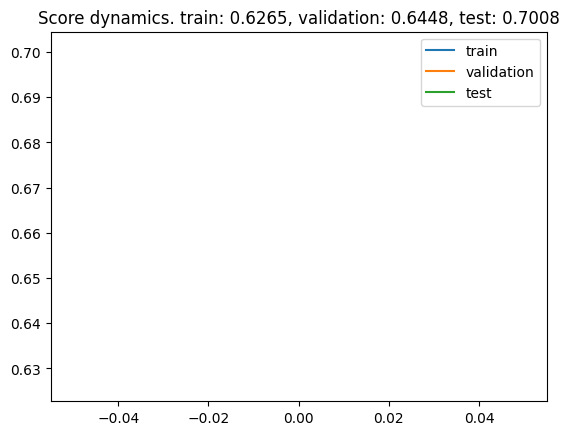

diffpool test quality: 0.70078603294772


In [ ]:
diffpool_model = DiffPool(8, 8, 16, out_dim=dataset.num_tasks).to(device)
run(diffpool_model, "diffpool")

### Task 6. Augmentation (3 points)

<img src='https://raw.githubusercontent.com/netspractice/advanced_gnn/made2021/assignment_contrastive_learning/contrastive_learning.png' width=500>

Source: https://arxiv.org/abs/2103.00111

Contrastive learning aims to learn representations by maximizing feature consistency under differently augmented views, that exploit data- or task-specific augmentations. In a case of graph representation learning, there are some augmentation techniques that can be used to produce graph embeddings for downstream tasks, say classification.

Write a class `GraphAugmentation` with a function `transform` that takes a graph and returns an augmented graph. Types of augmentation:
* `drop_nodes` — randomly drops a share of nodes with a given ratio
* `pert_edges` — randomly perturbs (rewires) a share of edges with a given ratio
* `attr_mask` — randomly masks a share of node attributes with a given ratio and a name in `ndata` collection
* `rw_subgraph` — builds a subgraph based on random walk
* `identical` — the same graph, no augmentation

Augmentations are applied to graphs with self-loops, so keep self-loops during edges perturbation. Parallel edges are allowed after perturbation. A random walk subgraph is constructed by (1) adding a random starting node, (2) adding all its neighbors, (3) adding all neighbors of a random node in the subgraph and repeating the step 3 while number of nodes exceeds the threshold `(1 - ratio)`.

In [ ]:
import random
class GraphAugmentation():
    def __init__(self, type, ratio=0.2, node_feat='attr'):
        self.type = type
        self.ratio = ratio
        self.node_feat = node_feat
    
    def transform(self, g):
        if self.type == 'drop_nodes':
            return self.drop_nodes(g)
        elif self.type == 'pert_edges':
            return self.pert_edges(g)
        elif self.type == 'attr_mask':
            return self.attr_mask(g)
        elif self.type == 'rw_subgraph':
            return self.rw_subgraph(g)
        elif self.type == 'identical':
            return g
    
    def drop_nodes(self, g):
        g_clone = g.clone()
        nodes = list(g_clone.nodes())
        random.shuffle(nodes)
        g_clone.remove_nodes(nodes[:int(len(nodes)*self.ratio)])
        return g_clone

    def pert_edges(self, g):
        g_clone = dgl.remove_self_loop(g)
        n_edges = g_clone.number_of_edges()
        n_perturb = int(n_edges * self.ratio)
        #save old edj
        src, dst = g_clone.all_edges()
        #new dist
        new_dst = list(dst)
        random.shuffle(new_dst)
        #delet edges wich will pert
        g_clone = dgl.remove_edges(g_clone, [e for e in range(n_perturb)]) #by index
        g_clone = dgl.add_edges(g_clone, src[:n_perturb], new_dst[:n_perturb])
        return dgl.add_self_loop(g_clone)

    def attr_mask(self, g):
        g_clone = g.clone()
        if True:
          feat_shape = g_clone.ndata[self.node_feat].shape[1]
          mask = np.random.rand(feat_shape) <  self.ratio
          g_clone.ndata[self.node_feat][:, mask] = 0
        return g_clone

    def rw_subgraph(self, g):
        g_clone = g.clone()
        g_nx = dgl.to_networkx(g_clone)
        n_nodes = g_clone.number_of_nodes()
        num_sample = int(n_nodes * self.ratio)
        all_nodes = list(g_nx.nodes())
        subgraph_nodes = set()
        #choose random
        node = random.choice(all_nodes)
        subgraph_nodes.add(node)
        subgraph_nodes.update(g_nx.neighbors(node))
        while len(subgraph_nodes) < num_sample:
          node = random.choice(list(subgraph_nodes))
          subgraph_nodes.update(g_nx.neighbors(node))
        subgraph = dgl.node_subgraph(g_clone, list(subgraph_nodes))
        return subgraph

In [ ]:
g = dgl.rand_graph(100, 300)
g = g.remove_self_loop()
g = g.add_self_loop()
g.ndata['attr'] = torch.ones(100, 10)
g

Graph(num_nodes=100, num_edges=398,
      ndata_schemes={'attr': Scheme(shape=(10,), dtype=torch.float32)}
      edata_schemes={})

In [ ]:
ratio = 0.7
aug = GraphAugmentation('drop_nodes', ratio=ratio)
aug_g = aug.transform(g)
assert aug_g.ndata['attr'].shape[1] == g.ndata['attr'].shape[1]
assert aug_g.ndata['attr'].shape[0] < g.ndata['attr'].shape[0]
assert aug_g.ndata['attr'].shape[0] == int(g.number_of_nodes() * (1 - ratio))
G = nx.Graph(aug_g.to_networkx())
assert np.isclose(nx.laplacian_spectrum(G), 0).sum() > 1

In [ ]:
aug = GraphAugmentation('pert_edges', ratio=0.2)
aug_g = aug.transform(g)
assert aug_g.ndata['attr'].shape == g.ndata['attr'].shape
assert aug_g.number_of_edges() == g.number_of_edges()
assert not torch.all(aug_g.adj().to_dense() == g.adj().to_dense())
assert torch.all(aug_g.adj().to_dense().diag() >= 1)

In [ ]:
aug = GraphAugmentation('attr_mask', ratio=0.2, node_feat='attr')
aug_g = aug.transform(g)
assert aug_g.ndata['attr'].shape == (100, 10)
mask = (aug_g.ndata['attr'][0, :] == 0).repeat(100, 1)
assert torch.all(aug_g.ndata['attr'][mask] == 0)
assert torch.all(aug_g.ndata['attr'][~mask] == 1)

In [ ]:
aug = GraphAugmentation('rw_subgraph', ratio=0.7)
aug_g = aug.transform(g)
assert aug_g.ndata['attr'].shape[1] == g.ndata['attr'].shape[1]
assert aug_g.ndata['attr'].shape[0] < g.ndata['attr'].shape[0]
G = nx.Graph(aug_g.to_networkx())
assert np.isclose(nx.laplacian_spectrum(G), 0).sum() == 1

### Task 7. Contrastive dataset (3 points)

We will fed augmented graphs into encoder during training to obtain graph embeddings. Let us prepare a graph contrastive dataset class so that each element in the dataset will represent augmented graphs and a label.

Write a class `ContrastiveDataset` with a function `__getitem__` that takes a graph's index and returns a tuple:
* an initial graph
* a graph after the first augmentation
* a graph after the second augmentation
* a label

In [317]:
class ContrastiveDataset(DGLDataset):
    def __init__(self, filename, augmentations):
        self.filename = filename
        self.graphs = None
        self.labels = None
        self.augmentations = augmentations
        assert len(self.augmentations) == 2
        super().__init__(name=filename)

    def process(self):
        graphs, graph_data = dgl.load_graphs(self.filename)
        self.graphs = graphs
        self.labels = graph_data['labels']

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        init_graph = self.graphs[idx].clone()
        aug_graph_1 = self.augmentations[0].transform(init_graph).clone()
        aug_graph_2 = self.augmentations[1].transform(init_graph).clone()
        g_label = self.labels[idx].clone()
        return (init_graph, aug_graph_1, aug_graph_2, g_label)
    
    def delete_items(self, remove_indices:list):
      g = self.graphs.copy()
      l = self.labels
      self.graphs = [i for j, i in enumerate(g) if j not in remove_indices]
      self.labels = [i for j, i in enumerate(l) if j not in remove_indices]

PROTEINS is a dataset with 1113 proteins where nodes are secondary structure elements and there is an edge between two nodes if they are neighbors in the amino-acid sequence or in 3D space. It has 3 discrete labels, representing helix, sheet or turn. Proteins are divided into two classes: enzymes and non-enzymes. Source: https://arxiv.org/abs/2007.08663.

Let us create a dataset with dropping nodes and masking attributes augmentations.

In [318]:
url = 'https://github.com/netspractice/advanced_gnn/raw/made2021/assignment_contrastive_learning/proteins.bin'
open('proteins.bin', 'wb').write(requests.get(url).content);

augmentations = []
augmentations.append(GraphAugmentation('drop_nodes', ratio=0.12))
augmentations.append(GraphAugmentation('attr_mask', ratio=0.4, node_feat='attr'))
dataset = ContrastiveDataset(filename='proteins.bin', augmentations=augmentations)
N = len(dataset)
N

1113

In [319]:
g, aug_g1, aug_g2, label = dataset[0]
assert g.ndata['attr'].shape == (42, 3)
assert aug_g1.ndata['attr'].shape == (37, 3)
assert g.ndata['attr'].sum() <= 42

Since we perform the random walk subgraph augmentation, we want to make sure all initial graphs are connected.

Write a function `connected_subset` that takes an initial dataset and returns a `torch.utils.data.dataset.Subset` with connected graphs only.

In [320]:
from torch.utils.data.dataset import Subset
def connected_subset(dataset):
    subset = []
    for g in dataset.graphs:
      g_nx = nx.Graph(g.to_networkx())
      if nx.is_connected(g_nx):
        subset.append(g)
    return Subset(subset, range(len(subset)))

In [321]:
from torch.utils.data.dataset import Subset
def connected_subset(dataset):
    subset = []
    for idx, data in enumerate(dataset):
      g, _, _, _ = data
      g_nx = nx.Graph(g.to_networkx())
      if nx.is_connected(g_nx):
        subset.append(idx)

    return Subset(dataset, subset)

In [322]:
c_dataset = connected_subset(dataset)
N = len(c_dataset)
assert N == 1067

Let us look at some graphs in the dataset.

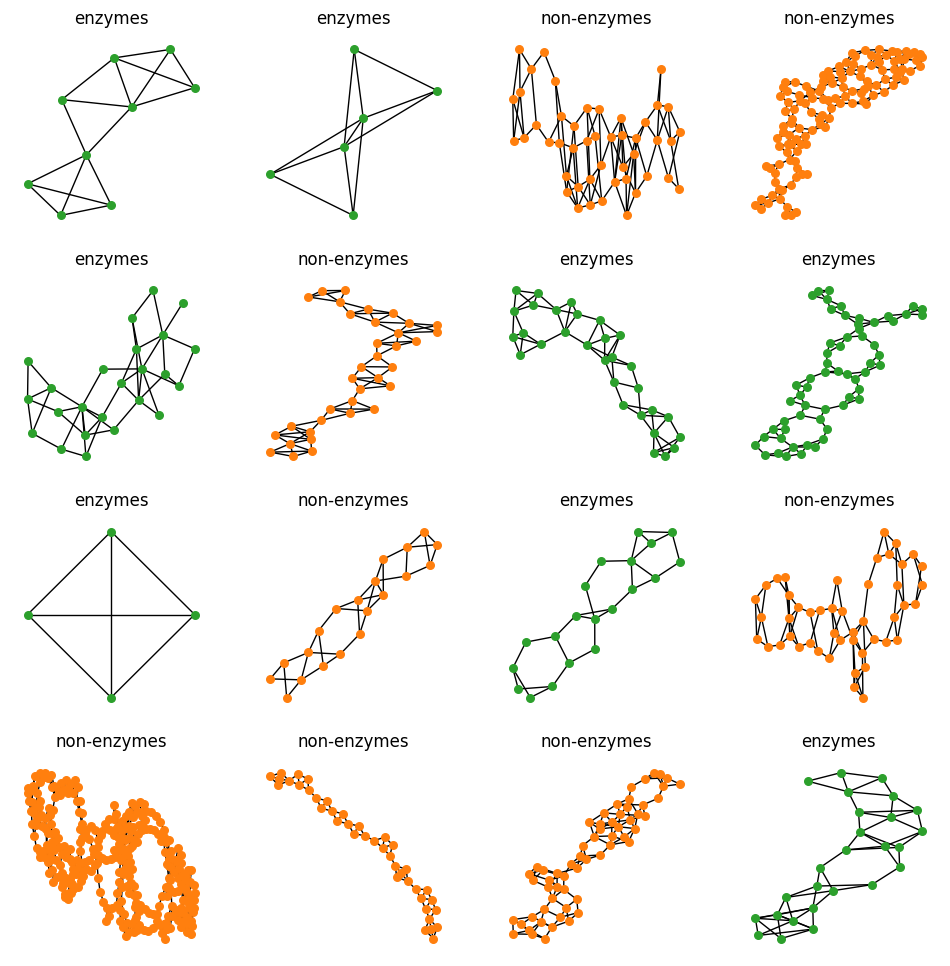

In [323]:
colors = ['tab:orange', 'tab:green']
plt.figure(figsize=(12, 12))
np.random.seed(0)
for i in range(16):
    plt.subplot(4, 4, i+1)
    g, _, _, l = c_dataset[np.random.randint(N)]
    g = nx.Graph(g.to_networkx())
    g.remove_edges_from(nx.selfloop_edges(g))
    nx.draw_kamada_kawai(g, node_size=30, node_color=colors[l])
    plt.title('enzymes' if l == 1 else 'non-enzymes')

### Task 8. Contrastive loss (3 points)

Let an encoder be the two-layers GCN (`GraphConv` in `dgl`) with mean graph pooling and two-layers MLP projection head. All layers except of input and output ones have `hidden_dim` dimensionality. Apply ReLU as an activation function.

Write a class `GCNEncoder` with a function `forward` that takes a batch of graphs, node attrubute name in `ndata` collection and returns graph embeddings.

In [324]:
class GCNEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.conv1 = GraphConv(input_dim, hidden_dim, activation=nn.ReLU())
        self.conv2 = GraphConv(hidden_dim, hidden_dim, activation=nn.ReLU())
        self.pooling = AvgPooling()
        self.proj_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, g, node_feat):
        h = self.conv1(g, g.ndata[node_feat])
        #print('con1',h.shape)
        h = self.conv2(g, h)
        #print('con2',h.shape)
        h = self.pooling(g, h)
        #print('pool',h.shape)
        h = self.proj_head(h)
        #print('proj',h.shape)
        #ему кидается батч графов, он перекодирует ноды
        #потом avrgpool усредняет ноды по каждому графу
        #получаем эмбендини каждого графа из батча
        #con1 torch.Size([36363, 32])
        #con2 torch.Size([36363, 32])
        #pool torch.Size([960, 32])
        #proj torch.Size([960, 16])
        return h

Let us check the logistic regression model on the untrained encoder output.

In [325]:
def train_test_split(c_dataset, train_idx, test_idx):
    graph_train_list = []
    y_train = []
    for idx in train_idx:
        graph, _, _, label = c_dataset[idx]
        graph_train_list.append(graph)
        y_train.append(label)
    
    graph_test = []
    y_test = []
    for idx in test_idx:
        graph, _, _, label = c_dataset[idx]
        graph_test.append(graph)
        y_test.append(label)
    #print('graph_train_list size:',len(graph_train_list))
    #print('graph_test list size:',len(graph_test))
    graph_train = dgl.batch(graph_train_list).to(device)
    graph_test = dgl.batch(graph_test).to(device)
    y_train = torch.tensor(y_train).to(device)
    y_test = torch.tensor(y_test).to(device)
    
    return graph_train, graph_test, y_train, y_test

np.random.seed(0)
ratio = [0.9, 0.1] # train test ratio
split_idx = ['train'] * int(ratio[0] * N) \
    + ['test'] * int(ratio[1] * N)
split_idx = np.random.permutation(split_idx)
train_idx = np.where(split_idx == 'train')[0]
test_idx = np.where(split_idx == 'test')[0]

graph_train, graph_test, y_train, y_test = train_test_split(
    c_dataset, train_idx, test_idx)
assert graph_train.ndata['attr'].shape == (36363, 3)
assert graph_test.ndata['attr'].shape == (3740, 3)
assert y_train.shape == (960, )
assert y_test.shape == (106, )

In [326]:
print(graph_train.ndata['attr'].shape)
print(graph_train.num_nodes())

torch.Size([36363, 3])
36363


Let us check the classification score and look at tSNE visualization.

In [327]:
encoder = GCNEncoder(input_dim=3, hidden_dim=32, output_dim=16)
encoder.to(device)

GCNEncoder(
  (conv1): GraphConv(
    in=3, out=32, normalization=both
    (_activation): ReLU()
  )
  (conv2): GraphConv(
    in=32, out=32, normalization=both
    (_activation): ReLU()
  )
  (pooling): AvgPooling()
  (proj_head): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
  )
)

In [328]:
def classification_score(graph_train, graph_test, y_train, y_test, encoder, show=True):
    
    with torch.no_grad():
        X_train = encoder(graph_train, 'attr').cpu()
        X_test = encoder(graph_test, 'attr').cpu()
    
    clf = LogisticRegression()
    clf.fit(X_train, y_train.cpu())
    score = clf.score(X_test, y_test.cpu())
    
    if show:
        plt.figure(figsize=(10, 6))
        cmap = plt.cm.Set1_r
        dec = TSNE(n_components=2)
        xy_emb = dec.fit_transform(X_train)
        plt.scatter(xy_emb[:, 0], xy_emb[:, 1], c=y_train.cpu(), cmap=cmap, s=5)
        plt.title('tSNE visualization')
        plt.show()
        print('Accuracy: {:.4f}'.format(score))
    
    return score

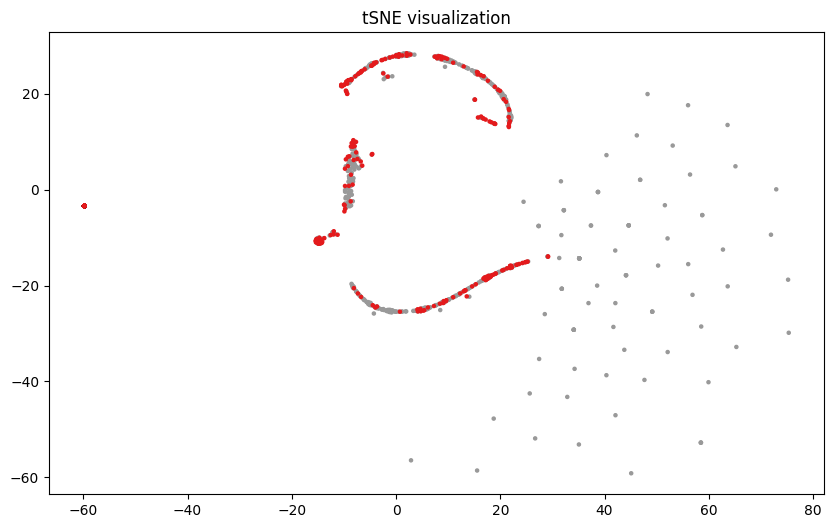

Accuracy: 0.5660


In [329]:
score = classification_score(graph_train, graph_test, y_train, y_test, encoder)

In graph contrastive learning, pre-training is performed through maximizing the agreement between two augmented views of the same graph via a contrastive loss in the latent space. Contrastive loss function is defined to enforce maximizing the consistency between positive pairs $z_i$, $z_j$ (the same graph under different augmentations) compared with negative pairs. Here we utilize the NT-Xent Loss that is defined for $n$-th graph in a batch of $N$ graphs as follows:

$$l_{n}=-\log \frac{\exp \left(\text{sim}(z_{n, i}, z_{n, j}) / \tau \right)}{\sum_{n'=1, n' \neq n}^{N} \exp \left( \text{sim}(z_{n, i}, z_{n', j}) / \tau \right)}$$

where $\text{sim}$ is cosine similarity $\text{sim}(z_i, z_j) = z_i^\top z_j / (\| z_i \| \cdot \| z_j \|)$ and $\tau$ is a temperature parameter.

Source: https://arxiv.org/pdf/2010.13902.pdf

Write a function `ntxent` that takes a batch of agmented graph embeddings `x1` and a batch of agmented graph embeddings `x2` and returns mean loss value among all graphs $L = \frac{1}{N}\sum_{n=1}^N l_n$.

_Hint: it is possible to use matrix operations only, with no loops._

In [338]:
def ntxent(x1, x2, temperature=0.1):
    
    vec_mul_matrix = x1 @ x2.T
    assert round(vec_mul_matrix[0,1].item(),3) == round((x1[0] @ x2[1]).item(), 3)
    #print(vec_mul_matrix)
    norms1 =  torch.linalg.vector_norm(x1, dim=1).reshape((1,x1.shape[0]))
    #print(norms1)
    norms2 = torch.linalg.vector_norm(x2, dim=1).reshape((1,x1.shape[0]))
    norm_matrix = norms1.T @ norms2
    #print(norm_matrix)
    assert norms1[0][1]*norms2[0][0] == norm_matrix[1,0]
    sim_matrix = vec_mul_matrix / norm_matrix
    assert sim_matrix[0,1] == vec_mul_matrix[0,1] / norm_matrix[0,1]
    #print(sim_matrix)
    sim_temp_matrix = sim_matrix/temperature
    #print(sim_temp_matrix)
    exp_sim_matrix = torch.exp(sim_temp_matrix)
    assert exp_sim_matrix[0,1] == torch.exp(sim_temp_matrix[0,1])

    exp_sim_norm_matrix = exp_sim_matrix
    diag_entries = torch.diagonal(exp_sim_norm_matrix)
    #print(exp_sim_norm_matrix)
    #print(diag_entries)

    offdiag_entries = exp_sim_norm_matrix - torch.diag(diag_entries)
    numen = diag_entries
    denom = torch.sum(offdiag_entries, axis=1)
    assert denom[0] == torch.sum(offdiag_entries[0])
    under_log = numen/denom
    assert under_log[1] == numen[1]/denom[1]
    loss_vector = -torch.log(under_log)
    assert loss_vector[1] == -torch.log(under_log[1])
    L = torch.mean(loss_vector)
    return L

In [339]:
x1 = torch.tensor([[1., 0.], [0., 1.]])
x2 = torch.tensor([[1., 0.], [0., 1.]])
assert ntxent(x1, x2) == -10

x1 = torch.tensor([[1., 0.], [0., 1.]])
x2 = torch.tensor([[0., 1.], [1., 0.]])
assert ntxent(x1, x2) == 10

torch.manual_seed(0)
x1 = torch.randn(128, 16)
x2 = torch.randn(128, 16)
assert round(ntxent(x1, x2).item(), 4) == 7.191

In [332]:
loader = GraphDataLoader(
    c_dataset,
    batch_size=64,
    drop_last=False,
    shuffle=True)

In [333]:
encoder = GCNEncoder(input_dim=3, hidden_dim=32, output_dim=16)
encoder.to(device)
opt = Adam(encoder.parameters(), lr=0.005)

Write a function `train` that takes augmented batches, makes optimization step and returns a loss value.

In [334]:
def train(encoder, aug_batch1, aug_batch2, opt):
    z1 = encoder(aug_batch1.to(device), 'attr')
    z2 = encoder(aug_batch2.to(device), 'attr')
    loss = ntxent(z1, z2)
    opt.zero_grad()
    loss.backward()
    opt.step()
    return loss.item()

In [335]:
for batch, aug_batch1, aug_batch2, label in loader:
    break
loss_item = train(encoder, aug_batch1, aug_batch2, opt)
assert type(loss_item) == float
assert loss_item > 0

In [336]:
print(aug_batch1.batch_size,label.shape)

64 torch.Size([64])


Here is a training loop that accumulates mean loss per epoch.

In [337]:
loss_vals = []
n_epochs = 30
for i in range(n_epochs):
    loss_epoch = []
    for batch, aug_batch1, aug_batch2, label in loader:
        loss_item = train(encoder, aug_batch1, aug_batch2, opt)
        loss_epoch.append(loss_item)
    loss_vals.append(sum(loss_epoch)/len(loss_epoch))
    plt.plot(loss_vals)
    plt.title('Contrastive loss. Epoch: {}/{}'.format(i+1, n_epochs))
    plt.show();
    clear_output(wait=True)

KeyboardInterrupt: ignored

In [ ]:
score = classification_score(graph_train, graph_test, y_train, y_test, encoder)
assert score > 0.65

As we see, we can noticeably improve classification score using self-supervised learning.

### Task 9. Tail prediction (1 points)

Here we aim to compare augmentation techniques and conclude which pair is better for PROTEINS dataset.

Write a function `run` that takes a filename with proteins, number of epochs and a list of types of augmentation. It returns a np.array with a classification score matrix where rows are first augmentation, columns are second augmentation. Since the matrix is asymptotically symmetric, calculate the upper triangle values only.

It can take time. To speed up the evaluation, return calculated score matrix without actual training:
```
def run(filename, n_epochs, augs):
    scores = [[0.5, 0.5, 0.5, 0.5, 0.5], [0, 0.5, 0.5, 0.5], ...
    return scores

    ### ACTUAL TRAINING
```

In [ ]:
def run(filename, n_epochs, augs):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
augs = ['drop_nodes', 'pert_edges', 'attr_mask', 'rw_subgraph', 'identical']
res = run('proteins.bin', n_epochs=30, augs=augs)
symm = (res.T + res - np.diag(res[range(5), range(5)])).sum(0)
assert np.all((res > 0).sum(0) == np.arange(5) + 1)
assert np.all(res[res > 0] > 0.6)
assert symm[0] > symm[4]
assert symm[2] > symm[4]

In [ ]:
pd.DataFrame(res, index=augs, columns=augs).round(4)